<a href="https://colab.research.google.com/github/OshanJayawardana/vip-cup/blob/main/Masked_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! wget "https://drive.google.com/uc?export=download&confirm=s5vl&id=1BFshZAWQgtYleZxLSfYbz-juJhpQkoGF" -c -O "data.rar"

In [ ]:
! unrar x "data.rar"

In [ ]:
! pip install torch_intermediate_layer_getter

In [ ]:
import sys
import os
import requests

import torch
import numpy as np
from torchvision import datasets
import torchvision
from torchsummary import summary
from sklearn.manifold import TSNE

from tqdm import tqdm

import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.pyplot import figure
from torch_intermediate_layer_getter import IntermediateLayerGetter as MidGetter

In [ ]:
# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
    !git clone https://github.com/facebookresearch/mae.git
    sys.path.append('./mae')
else:
    sys.path.append('..')
import models_mae

In [ ]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()
    return loss

def transform(img):
  img = img.resize((224, 224))
  img = np.array(img) / 255.

  assert img.shape == (224, 224, 3)

  # normalize by ImageNet mean and std
  img = img - imagenet_mean
  img = img / imagenet_std
  return img

In [ ]:
# This is an MAE model trained with an extra GAN loss for more realistic generation (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large_ganloss.pth

chkpt_dir = 'mae_visualize_vit_large_ganloss.pth'
model_mae_gan = prepare_model('mae_visualize_vit_large_ganloss.pth', 'mae_vit_large_patch16')
print('Model loaded.')

--2022-08-02 05:21:29--  https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large_ganloss.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1318315181 (1.2G) [binary/octet-stream]
Saving to: ‘mae_visualize_vit_large_ganloss.pth’

mae_visualize_vit_l 100%[===================>]   1.23G  25.6MB/s    in 57s     

2022-08-02 05:22:26 (22.2 MB/s) - ‘mae_visualize_vit_large_ganloss.pth’ saved [1318315181/1318315181]

<All keys matched successfully>
Model loaded.


In [ ]:
# EXAMPLE USAGE:
# instantiate the dataset and dataloader
data_dir = "/content/data"
dataloader = torchvision.datasets.ImageFolder(data_dir, transform)

In [ ]:
print(dataloader.class_to_idx)

{'real': 0, 'synt': 1}


1
MAE with extra GAN loss:


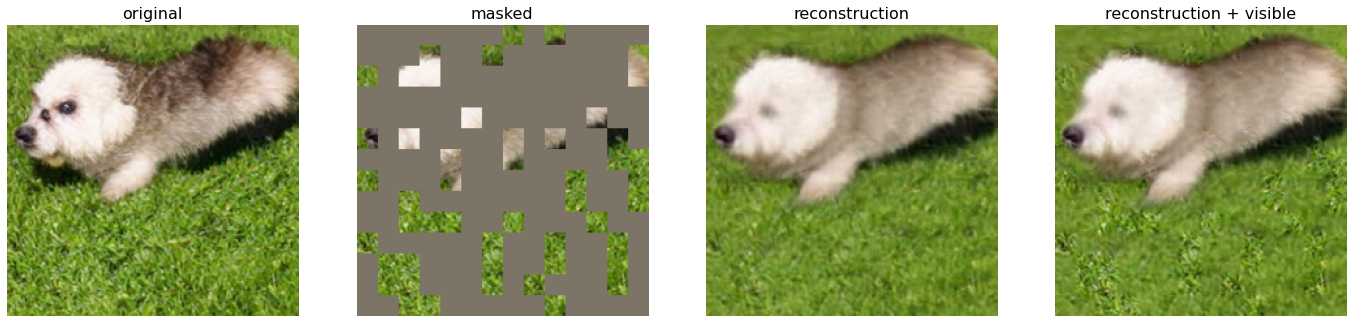

tensor(0.2764, grad_fn=<DivBackward0>)


In [ ]:
# make random mask reproducible (comment out to make it change)
indx = 583
print(dataloader[indx][1])
torch.manual_seed(2)
print('MAE with extra GAN loss:')
loss = run_one_image(dataloader[indx][0], model_mae_gan)
print(loss)

0
MAE with extra GAN loss:


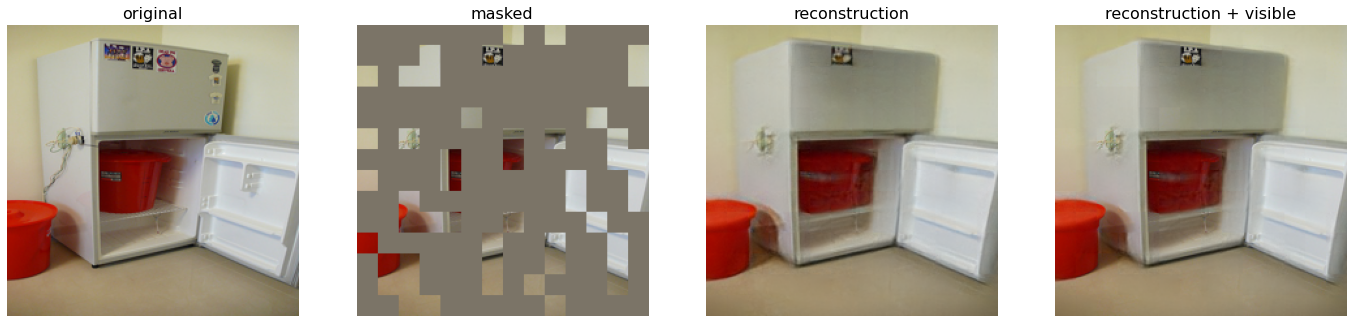

tensor(0.0655, grad_fn=<DivBackward0>)


In [ ]:
# make random mask reproducible (comment out to make it change)
indx = 257
print(dataloader[indx][1])
torch.manual_seed(2)
print('MAE with extra GAN loss:')
loss = run_one_image(dataloader[indx][0], model_mae_gan)
print(loss)

In [ ]:
loss_list=[]
for image,label in tqdm(dataloader):
  x = torch.tensor(image)
  # make it a batch-like
  x = x.unsqueeze(dim=0)
  x = torch.einsum('nhwc->nchw', x)
  loss, y, mask = model_mae_gan(x.float(), mask_ratio=0.75)
  loss_list.append(loss.item())

100%|██████████| 1000/1000 [15:44<00:00,  1.06it/s]


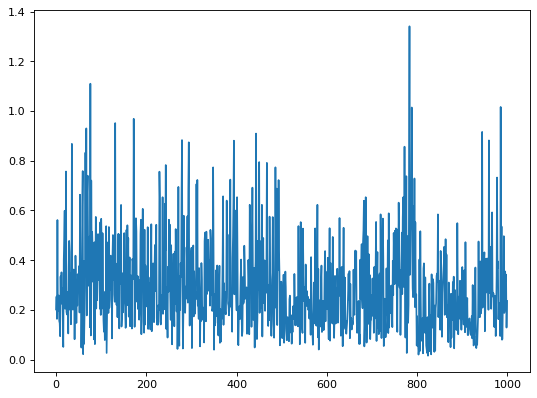

In [ ]:
y_loss = np.array(loss_list)
figure(figsize=(8, 6), dpi=80)
plt.plot(y_loss)

In [ ]:
for name, _ in model_mae_gan.named_modules():
    print(name)

In [ ]:
latent = {}
def get_latent(name):
    def hook(model, input, output):
        latent[name] = output.detach()
    return hook

In [ ]:
model_mae_gan.norm.register_forward_hook(get_latent('norm'))

In [ ]:
latent_list=[]
for image,label in tqdm(dataloader):
  x = torch.tensor(image)
  # make it a batch-like
  x = x.unsqueeze(dim=0)
  x = torch.einsum('nhwc->nchw', x)
  loss, y, mask = model_mae_gan(x.float(), mask_ratio=0)
  #mid_outputs, model_output = mid_getter(x.float(), mask_ratio=0.75)
  latent_list.append(latent["norm"])

100%|██████████| 1000/1000 [40:58<00:00,  2.46s/it]


In [ ]:
numpylist = []
cnt = 0
for el in latent_list:
  numpylist.append(el.detach().cpu().numpy())
numpy_arr = np.array(numpylist)

In [ ]:
numpy_arr.shape

(1000, 1, 197, 1024)

In [ ]:
np.save("embeddings", numpy_arr)

In [ ]:
y_labels = []
for image, label in dataloader:
  y_labels.append(label)

In [ ]:
enc_results = numpy_arr[:,0,:,:]
enc_results = np.mean(enc_results, 1)
enc_results.shape

(1000, 1024)

In [ ]:
X_embedded = TSNE(n_components=2).fit_transform(enc_results)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


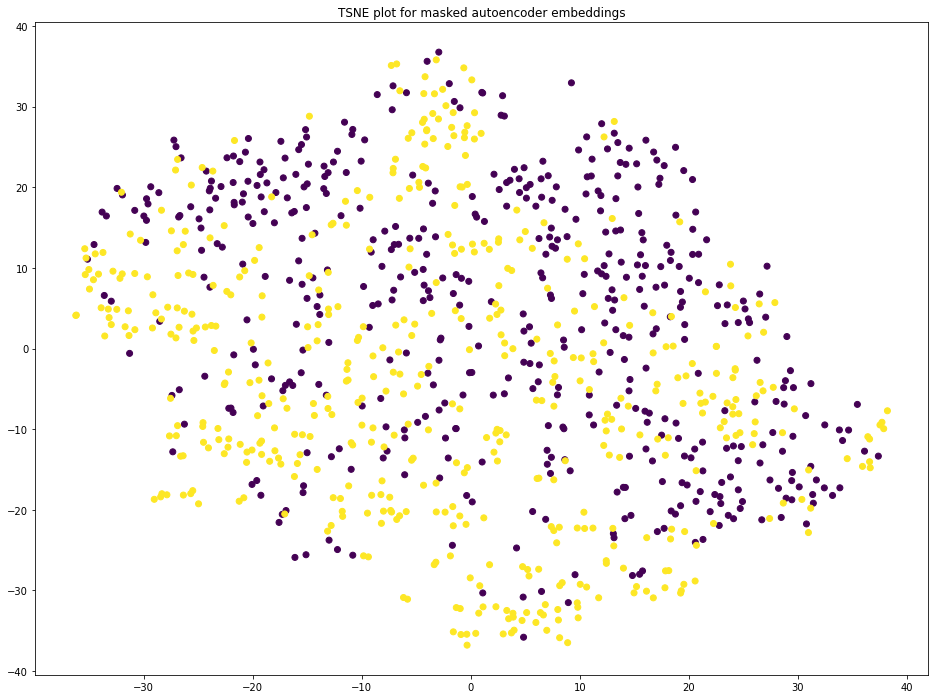

In [ ]:
fig = plt.figure(figsize=(16,12))
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=y_labels)
plt.title("TSNE plot for masked autoencoder embeddings")
plt.show()